In [1]:
%pip install -q dagshub mlflow

Note: you may need to restart the kernel to use updated packages.


# Import/setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb
import gc
import mlflow
import mlflow.sklearn
import os
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow'
os.environ['MLFLOW_TRACKING_USERNAME'] = 'g-kitiashvili'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '1c2227158cc19daf66bb3b241116a8e8c5f1cd20'

model_name = "XGBoost"
mlflow.set_experiment(f"{model_name}_Training")


<Experiment: artifact_location='mlflow-artifacts:/660b8cd046e7427cb512fcbceddff39c', creation_time=1745402039042, experiment_id='3', last_update_time=1745402039042, lifecycle_stage='active', name='XGBoost_Training', tags={}>

 # Data Loading and Preparation


In [3]:
print("Loading data...")


train_transaction = pd.read_csv('./data/train_transaction.csv')
test_transaction = pd.read_csv('./data/test_transaction.csv')

train_identity = pd.read_csv('./data/train_identity.csv')
test_identity = pd.read_csv('./data/test_identity.csv')

print(f"Train transaction shape: {train_transaction.shape}")
print(f"Test transaction shape: {test_transaction.shape}")
print(f"Train identity shape: {train_identity.shape}")
print(f"Test identity shape: {test_identity.shape}")

with mlflow.start_run(run_name=f"{model_name}_Initial_Preparation") as run:
    print("Merging data...")

    train = train_transaction.merge(train_identity, on='TransactionID', how='left')
    test = test_transaction.merge(test_identity, on='TransactionID', how='left')

    mlflow.log_param("train_original_shape", train.shape)
    mlflow.log_param("test_original_shape", test.shape)

    del train_transaction, train_identity
    gc.collect()

    target = 'isFraud'
    y_train = train[target].copy()
    train_transaction_id = train['TransactionID'].copy()
    test_transaction_id = test['TransactionID'].copy()

    fraud_ratio = y_train.mean()
    mlflow.log_param("fraud_ratio", fraud_ratio)
    print(f"Fraud ratio: {fraud_ratio:.4f}")

    X_train = train.drop(['isFraud'], axis=1)

    del train
    gc.collect()

Loading data...
Train transaction shape: (590540, 394)
Test transaction shape: (506691, 393)
Train identity shape: (144233, 41)
Test identity shape: (141907, 41)
Merging data...
Fraud ratio: 0.0350
🏃 View run XGBoost_Initial_Preparation at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/3/runs/eeb91369a55a4595b20f08f576d08790
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/3


 
 # Data Exploration for Pipeline Development


In [4]:
with mlflow.start_run(run_name=f"{model_name}_Exploration") as run:
    categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
    numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numerical_features.remove('TransactionID')  # Remove ID column

    mlflow.log_param("categorical_features_count", len(categorical_features))
    mlflow.log_param("numerical_features_count", len(numerical_features))

    missing_values = X_train.isnull().mean() * 100
    high_missing_cols = missing_values[missing_values > 80].index.tolist()

    mlflow.log_param("high_missing_cols_count", len(high_missing_cols))

    mlflow.log_param("transaction_amount_mean", X_train['TransactionAmt'].mean())
    mlflow.log_param("transaction_amount_std", X_train['TransactionAmt'].std())

    print(f"Categorical features: {len(categorical_features)}")
    print(f"Numerical features: {len(numerical_features)}")
    print(f"High missing columns: {len(high_missing_cols)}")


Categorical features: 31
Numerical features: 401
High missing columns: 74
🏃 View run XGBoost_Exploration at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/3/runs/6849ea5d763340dc935e06445fe8107c
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/3


# Creating pipeline

In [5]:
class HighMissingFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=80):
        self.threshold = threshold
        self.high_missing_cols = None

    def fit(self, X, y=None):
        missing_values = X.isnull().mean() * 100
        self.high_missing_cols = missing_values[missing_values > self.threshold].index.tolist()
        return self

    def transform(self, X):
        return X.drop(columns=self.high_missing_cols, errors='ignore')


class ConstantFeatureFilter(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.constant_features = None

    def fit(self, X, y=None):
        self.constant_features = [col for col in X.columns if X[col].nunique() <= 1]
        return self

    def transform(self, X):
        return X.drop(columns=self.constant_features, errors='ignore')


class DatetimeFeatureGenerator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        if 'TransactionDT' in X_new.columns:
            X_new['TransactionDay'] = X_new['TransactionDT'] / (24 * 60 * 60)

            X_new['DayOfWeek'] = np.floor(X_new['TransactionDay'] % 7)

            X_new['Hour'] = np.floor((X_new['TransactionDT'] % (24 * 60 * 60)) / 3600)

            X_new['IsWeekend'] = np.where(X_new['DayOfWeek'] >= 5, 1, 0)

            X_new = X_new.drop(['TransactionDT'], axis=1)

        return X_new


class CategoryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']).columns:
            le = LabelEncoder()
            # Fit including missing values
            values = X[col].fillna('missing').astype(str).values
            le.fit(values)
            self.encoders[col] = le
        return self

    def transform(self, X):
        X_new = X.copy()
        for col, encoder in self.encoders.items():
            if col in X_new.columns:
                values = X_new[col].fillna('missing').astype(str).values

                try:
                    X_new[col] = encoder.transform(values)
                except ValueError as e:
                    unknown_mask = ~np.isin(values, encoder.classes_)

                    if unknown_mask.any():
                        print(
                            f"Warning: Column {col} has {np.sum(unknown_mask)} unseen categories. Treating as 'missing'.")

                        values_fixed = values.copy()
                        values_fixed[unknown_mask] = 'missing'

                        try:
                            X_new[col] = encoder.transform(values_fixed)
                        except ValueError:
                            X_new[col] = np.zeros(len(values))
                            print(f"Warning: 'missing' not in classes for {col}. Using zeros.")
        return X_new


class MissingValueHandler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        for col in X_new.select_dtypes(include=['int64', 'float64']).columns:
            X_new[col] = X_new[col].fillna(-999)

        return X_new


class InteractionFeatureCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        if 'TransactionAmt' in X_new.columns:
            X_new['TransactionAmt_Log'] = np.log1p(X_new['TransactionAmt'])

        if 'P_emaildomain' in X_new.columns and 'R_emaildomain' in X_new.columns:
            X_new['email_match'] = (X_new['P_emaildomain'] == X_new['R_emaildomain']).astype(int)

        if 'card1' in X_new.columns:
            card1_counts = X_new['card1'].value_counts().to_dict()
            X_new['card1_count'] = X_new['card1'].map(card1_counts).fillna(1)

        if 'addr1' in X_new.columns:
            addr1_counts = X_new['addr1'].value_counts().to_dict()
            X_new['addr1_count'] = X_new['addr1'].map(addr1_counts).fillna(1)

        return X_new





# Data Preprocessing and training

In [6]:
def process_data(X_data, fit=False, X_train_ref=None):
    if fit:
        missing_values = X_data.isnull().mean() * 100
        high_missing_cols = missing_values[missing_values > 80].index.tolist()
        constant_features = [col for col in X_data.columns if X_data[col].nunique() <= 1]
    else:
        high_missing_cols = X_train_ref['high_missing_cols']
        constant_features = X_train_ref['constant_features']

    X_processed = X_data.drop(columns=high_missing_cols + constant_features, errors='ignore')

    if 'TransactionDT' in X_processed.columns:
        X_processed['TransactionDay'] = X_processed['TransactionDT'] / (24 * 60 * 60)
        X_processed['DayOfWeek'] = np.floor(X_processed['TransactionDay'] % 7)
        X_processed['Hour'] = np.floor((X_processed['TransactionDT'] % (24 * 60 * 60)) / 3600)
        X_processed['IsWeekend'] = np.where(X_processed['DayOfWeek'] >= 5, 1, 0)
        X_processed = X_processed.drop(['TransactionDT'], axis=1)

    label_encoders = {}
    for col in X_processed.select_dtypes(include=['object']).columns:
        if fit:
            le = LabelEncoder()
            X_processed[col] = X_processed[col].fillna('missing')
            le.fit(X_processed[col].astype(str))
            X_processed[col] = le.transform(X_processed[col].astype(str))
            label_encoders[col] = le
        else:
            le = X_train_ref['label_encoders'].get(col)
            if le is not None:
                X_processed[col] = X_processed[col].fillna('missing')
                try:
                    X_processed[col] = le.transform(X_processed[col].astype(str))
                except ValueError:
                    X_processed[col] = X_processed[col].map(
                        lambda x: next((i for i, val in enumerate(le.classes_) if val == str(x)), 0)
                    )

    for col in X_processed.select_dtypes(include=['int64', 'float64']).columns:
        X_processed[col] = X_processed[col].fillna(-999)

    if 'TransactionAmt' in X_processed.columns:
        X_processed['TransactionAmt_Log'] = np.log1p(X_processed['TransactionAmt'])

    if 'P_emaildomain' in X_processed.columns and 'R_emaildomain' in X_processed.columns:
        X_processed['email_match'] = (X_processed['P_emaildomain'] == X_processed['R_emaildomain']).astype(int)

    if 'card1' in X_processed.columns:
        card1_counts = X_processed['card1'].value_counts().to_dict()
        X_processed['card1_count'] = X_processed['card1'].map(card1_counts).fillna(1)

    if 'addr1' in X_processed.columns:
        addr1_counts = X_processed['addr1'].value_counts().to_dict()
        X_processed['addr1_count'] = X_processed['addr1'].map(addr1_counts).fillna(1)

    if fit:
        metadata = {
            'high_missing_cols': high_missing_cols,
            'constant_features': constant_features,
            'label_encoders': label_encoders
        }
        return X_processed, metadata
        
    return X_processed


X_train_processed, train_metadata = process_data(X_train, fit=True)


# CrossValidation and tuning

In [7]:
with mlflow.start_run(run_name=f"{model_name}_Cross_Validation") as run:
    X_train_cv, X_val, y_train_cv, y_val = train_test_split(
        X_train_processed, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    mlflow.log_param("validation_split", 0.2)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_size", X_train_cv.shape[0])
    mlflow.log_param("validation_size", X_val.shape[0])

    params = {
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'scale_pos_weight': (1 - fraud_ratio) / fraud_ratio,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'random_state': 42,
        'use_label_encoder': False
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train_cv, y_train_cv)

    y_val_pred = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, y_val_pred)
    precision, recall, _ = precision_recall_curve(y_val, y_val_pred)
    pr_auc = auc(recall, precision)

    mlflow.log_metric("validation_auc", val_auc)
    mlflow.log_metric("validation_pr_auc", pr_auc)

    for param, value in params.items():
        mlflow.log_param(param, value)

    print(f"Cross-validation complete.")
    print(f"AUC: {val_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")

with mlflow.start_run(run_name=f"{model_name}_Hyperparameter_Tuning") as run:
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1]
    }

    mlflow.log_param("tuning_n_estimators", param_grid['n_estimators'])
    mlflow.log_param("tuning_max_depth", param_grid['max_depth'])
    mlflow.log_param("tuning_learning_rate", param_grid['learning_rate'])

    best_auc = 0
    best_params = {}

    param_combos = [
        {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1},
        {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1},
        {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1},
        {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.01}
    ]

    for params in param_combos:
        n_estimators = params['n_estimators']
        max_depth = params['max_depth']
        learning_rate = params['learning_rate']

        print(f"Testing n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate}...")

        xgb_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'scale_pos_weight': (1 - fraud_ratio) / fraud_ratio,
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'random_state': 42,
            'use_label_encoder': False
        }

        model = xgb.XGBClassifier(**xgb_params)
        model.fit(X_train_cv, y_train_cv)

        y_val_pred = model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_pred)
        precision, recall, _ = precision_recall_curve(y_val, y_val_pred)
        pr_auc = auc(recall, precision)

        mlflow.log_metric(f"auc_n{n_estimators}_d{max_depth}_lr{learning_rate}", val_auc)
        mlflow.log_metric(f"pr_auc_n{n_estimators}_d{max_depth}_lr{learning_rate}", pr_auc)

        print(f"AUC: {val_auc:.4f}, PR-AUC: {pr_auc:.4f}")

        if val_auc > best_auc:
            best_auc = val_auc
            best_params = {
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'learning_rate': learning_rate
            }

    mlflow.log_params(best_params)
    mlflow.log_metric("best_auc", best_auc)

    print(f"Best parameters: {best_params}")
    print(f"Best validation AUC: {best_auc:.4f}")



Cross-validation complete.
AUC: 0.9278
PR AUC: 0.6173
🏃 View run XGBoost_Cross_Validation at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/3/runs/a210b5d273de45e687c2091b2ccd0888
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/3
Testing n_estimators=100, max_depth=3, learning_rate=0.1...
AUC: 0.8910, PR-AUC: 0.4986
Testing n_estimators=100, max_depth=6, learning_rate=0.1...
AUC: 0.9278, PR-AUC: 0.6173
Testing n_estimators=200, max_depth=6, learning_rate=0.1...
AUC: 0.9444, PR-AUC: 0.6786
Testing n_estimators=100, max_depth=6, learning_rate=0.01...
AUC: 0.8786, PR-AUC: 0.4601
Best parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1}
Best validation AUC: 0.9444
🏃 View run XGBoost_Hyperparameter_Tuning at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/3/runs/39a1cb3202974944b3e4a4214ddf5d40
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experimen

# Final Training with Full Dataset and feature analysis


Training final model on full dataset...
Processing test data...


2025/04/23 16:12:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'XGBoost_Model' already exists. Creating a new version of this model...
2025/04/23 16:12:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost_Model, version 4
Created version '4' of model 'XGBoost_Model'.


Final model registered as: XGBoost_Model
Submission file saved as: xgboost_submission_20250423_1612.csv
Feature importance analysis complete.
🏃 View run XGBoost_Final_Training at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/3/runs/754ca8d92ef4480d953541faf416c5a3
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment2.mlflow/#/experiments/3


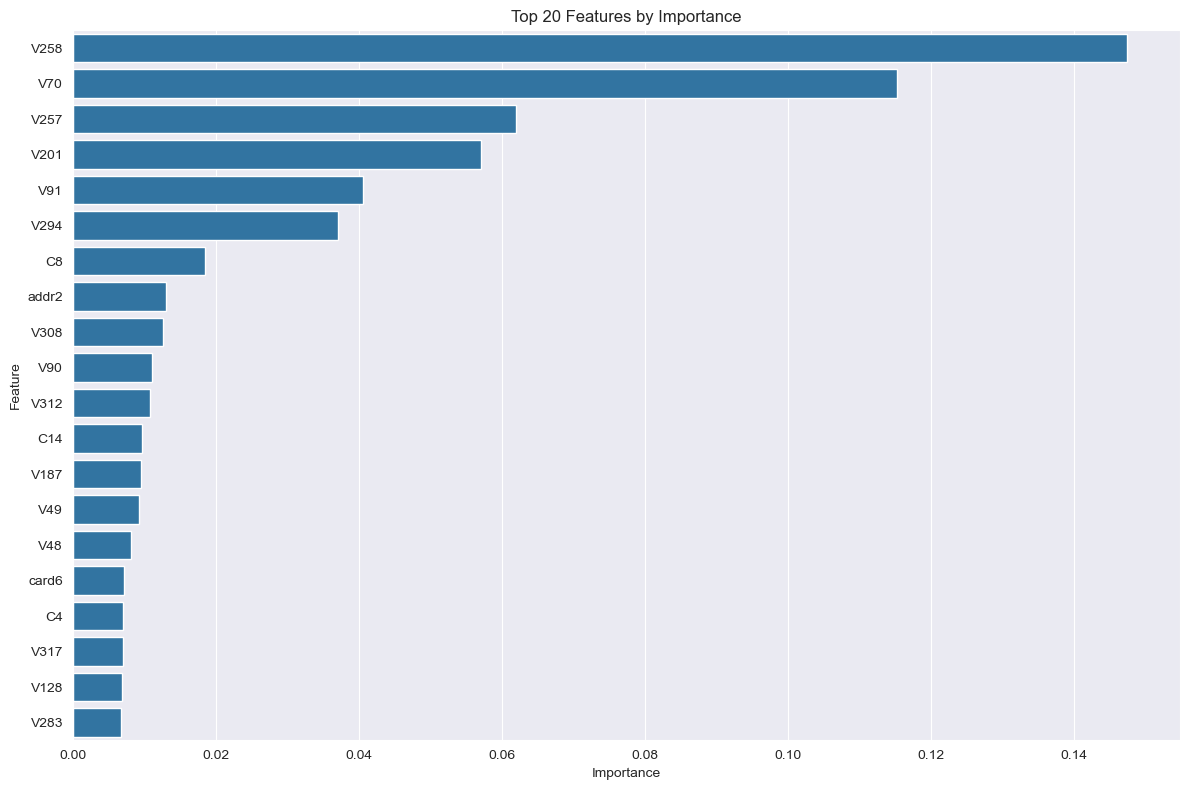

In [8]:
with mlflow.start_run(run_name=f"{model_name}_Final_Training") as run:
    final_params = best_params if 'best_params' in locals() and best_params else {
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.1
    }

    mlflow.log_params(final_params)

    print("Training final model on full dataset...")

    xgb_params = {
        'n_estimators': final_params.get('n_estimators', 100),
        'max_depth': final_params.get('max_depth', 6),
        'learning_rate': final_params.get('learning_rate', 0.1),
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'scale_pos_weight': (1 - fraud_ratio) / fraud_ratio,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'random_state': 42,
        'use_label_encoder': False
    }

    final_model = xgb.XGBClassifier(**xgb_params)
    final_model.fit(X_train_processed, y_train)

    print("Processing test data...")
    X_test_processed = process_data(test, fit=False, X_train_ref=train_metadata)

    for col in X_train_processed.columns:
        if col not in X_test_processed.columns:
            X_test_processed[col] = 0

    X_test_processed = X_test_processed[X_train_processed.columns]

    test_probs = final_model.predict_proba(X_test_processed)[:, 1]

    submission = pd.DataFrame({
        'TransactionID': test_transaction_id,
        'isFraud': test_probs
    })

    submission_file = f"xgboost_submission_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
    submission.to_csv(submission_file, index=False)

    mlflow.log_artifact(submission_file)

    mlflow.sklearn.log_model(final_model, "xgboost_model")

    model_registry_name = f"{model_name}_Model"
    model_description = f"{model_name} model with preprocessing"

    try:
        mlflow.register_model(
            f"runs:/{run.info.run_id}/xgboost_model",
            model_registry_name,
            tags={"description": model_description}
        )
        print(f"Final model registered as: {model_registry_name}")
    except Exception as e:
        print(f"Error registering model: {e}")

    print(f"Submission file saved as: {submission_file}")

    # Feature Importance Analysis
    feature_importance = final_model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X_train_processed.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Features by Importance')
    plt.tight_layout()

    importance_plot = "xgboost_feature_importance.png"
    plt.savefig(importance_plot)
    mlflow.log_artifact(importance_plot)

    mlflow.log_param("top_features", importance_df['Feature'].head(20).tolist())

    print("Feature importance analysis complete.")

